# Final Project DSAH Angin
*Members:*
1. Kianutama Radianur
2. Ahmad Satryaji A.
3. Sukma Firdaus
4. Elvan Rizky N.

### Initialization

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

# Surpress warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Do stuff here

In [2]:
# import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

### Load Datasets

In [3]:
df = pd.read_csv("spam.csv", usecols = ["Mark", "Message"])
df["Message"] = df["Message"].astype("str")
df["Mark"] = df["Mark"].astype("str")
dic = pd.read_csv("dictionary.csv")
norm = pd.read_csv("key_norm.csv")

In [4]:
df.dtypes

Mark       object
Message    object
dtype: object

In [5]:
df.head()

,Mark,Message
0,nSpam,BAREKSA: Silakan tandatangani FPR di : https:/...
1,nSpam,Terimakasih. Nomor ini telah terdaftar untuk v...
2,nSpam,Mohon maaf transaksi pembelian/penjualan/penga...
3,nSpam,Mohon maaf transaksi pembelian/penjualan/penga...
4,nSpam,Mohon maaf transaksi reksadana Anda di Bareksa...


In [6]:
df.groupby('Mark').describe()

Message                                                               
        count unique                                                top freq
Mark                                                                        
Spam     2624   1378  Pelanggan Yth, Pulsa Anda tdk cukup. Tersedia ...  244
nSpam     479    427  Anda sukses membeli Niantic, Inc. - 100 Pok\u0...    9

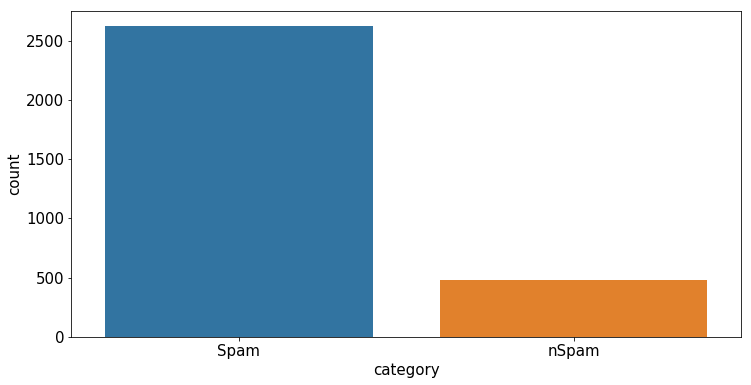

In [7]:
category_count = pd.DataFrame()
category_count['count'] = df['Mark'].value_counts()
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = category_count.index, y = category_count['count'], ax = ax)
ax.set_ylabel('count', fontsize = 15)
ax.set_xlabel('category',fontsize = 15)
ax.tick_params(labelsize=15)

### Data Cleaning

In [8]:
# Punctuation removal
def remove_punct(text):
    text = "".join([char if char not in string.punctuation else " " for char in text ])
    text = re.sub('[0-9]+', '', text) # Remove numbers
    return text

df["Message"] = df["Message"].apply(lambda x: remove_punct(x))
df.head()

,Mark,Message
0,nSpam,BAREKSA Silakan tandatangani FPR di https ...
1,nSpam,Terimakasih Nomor ini telah terdaftar untuk v...
2,nSpam,Mohon maaf transaksi pembelian penjualan penga...
3,nSpam,Mohon maaf transaksi pembelian penjualan penga...
4,nSpam,Mohon maaf transaksi reksadana Anda di Bareksa...


In [9]:
# Kata tidak baku ke baku
norm_dic = pd.Series(norm.hasil.values,index=norm.singkat).to_dict()

def replace_norm(text):
    text_tokenized = nltk.word_tokenize(text.lower())
    text = " ".join(word if word not in norm_dic else norm_dic[word] for word in text_tokenized)
    return text

df["Message"] = df["Message"].apply(lambda x: replace_norm(x))
df.head()

,Mark,Message
0,nSpam,bareksa silakan tandatangani fpr di https m ba...
1,nSpam,terimakasih nomor ini telah terdaftar untuk ve...
2,nSpam,mohon maaf transaksi pembelian penjualan penga...
3,nSpam,mohon maaf transaksi pembelian penjualan penga...
4,nSpam,mohon maaf transaksi reksadana anda di bareksa...


In [10]:
# Stemming
sf = StemmerFactory()
stemmer = sf.create_stemmer()
df["Message"] = df["Message"].map(stemmer.stem)
df.head()

,Mark,Message
0,nSpam,bareksa sila tandatangani fpr di https m barek...
1,nSpam,terimakasih nomor ini telah daftar untuk verif...
2,nSpam,mohon maaf transaksi beli jual alih reksadana ...
3,nSpam,mohon maaf transaksi beli jual alih reksadana ...
4,nSpam,mohon maaf transaksi reksadana anda di bareksa...


### Feature Extraction
#### Bag of Words

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Vectorize
bow_transformer = CountVectorizer().fit(df["Message"])
# print total number of vocab words
print("Jumlah total vocabulary:",len(bow_transformer.vocabulary_))
# example of vectorized text
sample_tweet = df["Message"][50]
# Vector representation
bow_sample = bow_transformer.transform([sample_tweet])
print("Representasi vektor \"{}\"\n{}".format(sample_tweet, bow_sample))

Jumlah total vocabulary: 2978
Representasi vektor "promo panjang dapat potong rp bulan total cashback hingga juta hanya di xl prioritas daftar di xl center atau hubung mp"
  (0, 152)	1
  (0, 393)	1
  (0, 434)	1
  (0, 445)	1
  (0, 536)	1
  (0, 545)	1
  (0, 601)	2
  (0, 931)	1
  (0, 970)	1
  (0, 1003)	1
  (0, 1166)	1
  (0, 1639)	1
  (0, 1848)	1
  (0, 1962)	1
  (0, 1979)	1
  (0, 1990)	1
  (0, 2143)	1
  (0, 2631)	1
  (0, 2892)	2


In [12]:
messages_bow = bow_transformer.transform(df["Message"])
# Check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Bag of words sparse matrix shape: ', messages_bow.shape)
print('Non zero occurences: ', messages_bow.nnz)

Bag of words sparse matrix shape:  (3103, 2978)
Non zero occurences:  56540


#### Tf-Idf

In [13]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 2892)	0.24925433442255016
  (0, 2631)	0.2287143601617586
  (0, 2143)	0.14371076600770305
  (0, 1990)	0.17052627592820724
  (0, 1979)	0.27440760133721204
  (0, 1962)	0.29117614488015126
  (0, 1848)	0.2060326522511755
  (0, 1639)	0.3078513831810921
  (0, 1166)	0.263916735034438
  (0, 1003)	0.15891635093864537
  (0, 970)	0.22545947429634342
  (0, 931)	0.17459555369838425
  (0, 601)	0.2037231259890517
  (0, 545)	0.15740869217038875
  (0, 536)	0.2557944226895001
  (0, 445)	0.26891200644731855
  (0, 434)	0.2938552187326394
  (0, 393)	0.22998646620642504
  (0, 152)	0.13796107477496136


### Classification

In [14]:
from sklearn.pipeline import Pipeline

# Create pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', None), # do not set classifier yet
])

# Pipeline params for tuning
parameters = {'bow__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False)}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,make_scorer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Classifiers
clfs = {}
clfs["AdaBoost"] = AdaBoostClassifier()
clfs["Naive Bayes - Bernoulli"] = BernoulliNB()
clfs["Naive Bayes - Multinomial"] = MultinomialNB()
clfs["GradientBoosting"] = GradientBoostingClassifier()
clfs["RandomForest"] = RandomForestClassifier()
clfs["LogisticRegression"] = LogisticRegression()
clfs["SVC"] = SVC()

# Metrics

scoring = {
    'accuracy': 'accuracy',
    'recall': make_scorer(recall_score, pos_label="nSpam"),
    'precision': make_scorer(precision_score, pos_label="nSpam"),
    'roc_auc': 'roc_auc',
}

grid_searches = {}
# Do 10-fold cross validation for each model for each of the 4 possible param combinations
folds = 10
for clf in clfs:
    print("Running GridSearchCV for {}.".format(clf))
    pipeline.set_params(classifier = clfs[clf])
    grid = GridSearchCV(pipeline, cv=folds, param_grid=parameters, scoring=scoring, refit="accuracy")
    grid.fit(df["Message"],df["Mark"])
    grid_searches[clf] = grid

Running GridSearchCV for AdaBoost.


In [54]:
def score_summary(grid_searches, sort_by='mean_accuracy'):
    def row(key, scores, times, params, precision, recall, roc):
        d = {
             'estimator': key,
             'mean_accuracy': np.mean(scores),
             'std_score': np.std(scores),
             'time': "{:.2f}s".format(np.sum(times)),
             'mean_precision': np.mean(precision),
             'mean_recall': np.mean(recall),
             'mean_roc': np.mean(roc),
        }
        return pd.Series({**params,**d})

    rows = []
    for k in grid_searches:
        params = grid_searches[k].cv_results_['params']
        scores, times, precisions, recalls, rocs = [], [], [], [], []
        for i in range(grid_searches[k].cv):
            #Construct scores
            key = "split{}_test_accuracy".format(i)
            r = grid_searches[k].cv_results_[key]
            scores.append(r.reshape(len(params),1))

            #Construct times
            t = grid_searches[k].cv_results_["mean_fit_time"]
            times.append(t.reshape(len(params),1))

            #Construct precisions, recalls, rocs
            precisions.append(grid_searches[k].cv_results_["split{}_test_precision".format(i)].reshape(len(params),1))
            recalls.append(grid_searches[k].cv_results_["split{}_test_recall".format(i)].reshape(len(params),1))
            rocs.append(grid_searches[k].cv_results_["split{}_test_roc_auc".format(i)].reshape(len(params),1))

        all_scores = np.hstack(scores)
        all_times = np.hstack(times)
        all_p = np.hstack(precisions)
        all_r = np.hstack(recalls)
        all_roc = np.hstack(rocs)
        
        for p, s, t, a, r, roc in zip(params,all_scores,all_times,all_p,all_r,all_roc):
            rows.append((row(k, s, t, p, a, r, roc)))

    df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

    columns = ['estimator', 'time', 'mean_accuracy', 'mean_precision', 'mean_recall', 'mean_roc', 'std_score']
    columns = columns + [c for c in df.columns if c not in columns]

    return df[columns]

score_summary(grid_searches).reset_index(drop=True)

,estimator,time,mean_accuracy,mean_precision,mean_recall,mean_roc,std_score,bow__ngram_range,tfidf__use_idf
0,RandomForest,1.55s,0.901017,0.933774,0.953104,0.859905,0.0455118,"(1, 1)",True
1,GradientBoosting,20.10s,0.892621,0.918134,0.960345,0.830297,0.0519244,"(1, 2)",False
2,GradientBoosting,8.44s,0.89197,0.911467,0.968737,0.833231,0.0536278,"(1, 1)",False
3,RandomForest,3.78s,0.891012,0.927007,0.947778,0.872389,0.0569428,"(1, 2)",False
4,LogisticRegression,0.63s,0.888104,0.910576,0.964147,0.914753,0.0662089,"(1, 1)",False
5,LogisticRegression,1.33s,0.886482,0.907134,0.966817,0.928026,0.0682902,"(1, 2)",False
6,LogisticRegression,0.62s,0.880019,0.901944,0.965287,0.902288,0.072453,"(1, 1)",True
7,LogisticRegression,1.34s,0.880015,0.897421,0.971772,0.907908,0.0734882,"(1, 2)",True
8,Naive Bayes - Multinomial,0.60s,0.879424,0.889505,0.982456,0.911429,0.0372722,"(1, 1)",True
9,Naive Bayes - Multinomial,0.63s,0.875567,0.87909,0.990845,0.92483,0.032075,"(1, 1)",False
